In [13]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [14]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── model

7 directories


In [15]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(os.listdir(IMG_PATH))
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)

['no', 'yes', 'brain_tumor_dataset']
98
['no', 'yes', 'brain_tumor_dataset']
155
['no', 'yes', 'brain_tumor_dataset']


In [16]:
dataset_dir = "/kaggle/working/TRAIN/"
test_dir = "/kaggle/working/TEST/"

In [17]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [18]:
def image_gen(height, width, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds, val_ds, test_ds

    

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


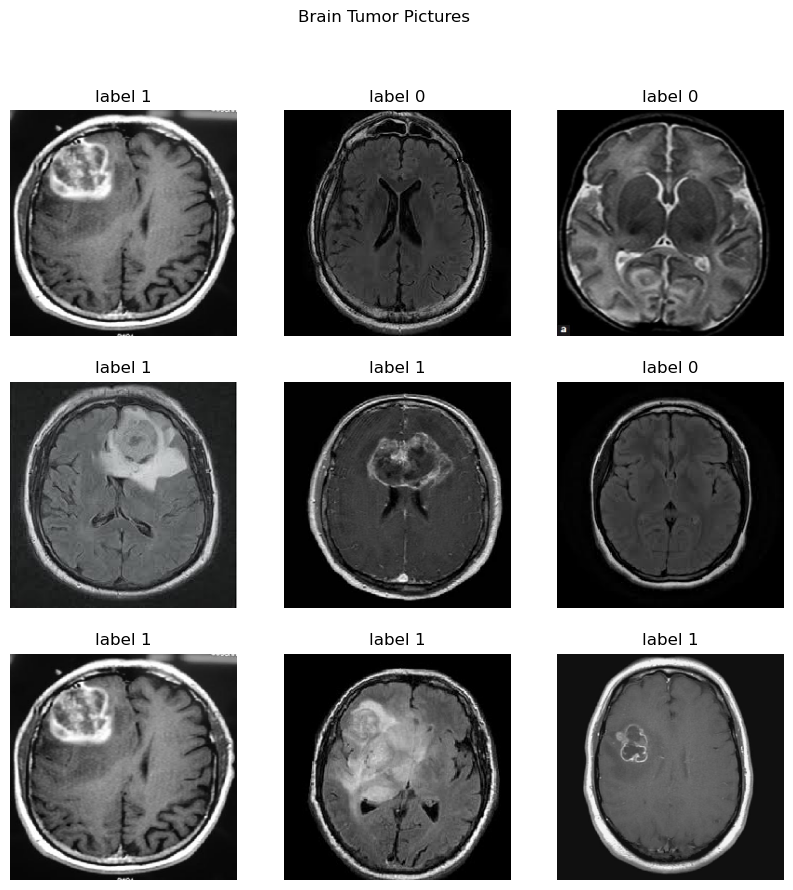

In [19]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

# 1. ResNet50V2


In [20]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [21]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7282
Epoch 1: accuracy improved from -inf to 0.72821, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 6s 484ms/step - loss: 0.5650 - accuracy: 0.7282 - val_loss: 0.3280 - val_accuracy: 0.8958
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8513
Epoch 2: accuracy improved from 0.72821 to 0.85128, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 286ms/step - loss: 0.4118 - accuracy: 0.8513 - val_loss: 0.3651 - val_accuracy: 0.8542
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.8872
Epoch 3: accuracy improved from 0.85128 to 0.88718, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 313ms/step - loss: 0.1759 - accuracy: 0.8872 - val_loss: 0.1702 - val_accuracy: 0.9167
Epoch 4/30
7/7 [==============================] - ETA: 0s - l

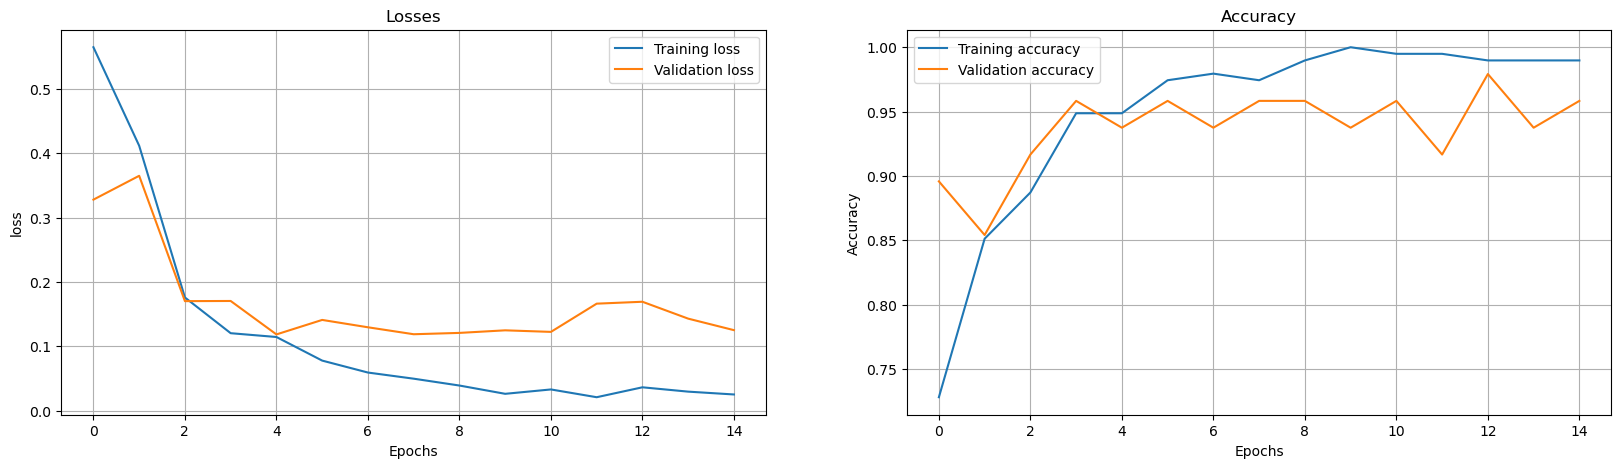

In [23]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [24]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8889
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 608ms/step - loss: 0.3070 - accuracy: 0.8889 - val_loss: 0.1294 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9012
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 575ms/step - loss: 0.2340 - accuracy: 0.9012 - val_loss: 0.1122 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.8971
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 666ms/step - loss: 0.2247 - accuracy: 0.8971 - val_loss: 0.0705 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9383
Epoch 4: accuracy did no

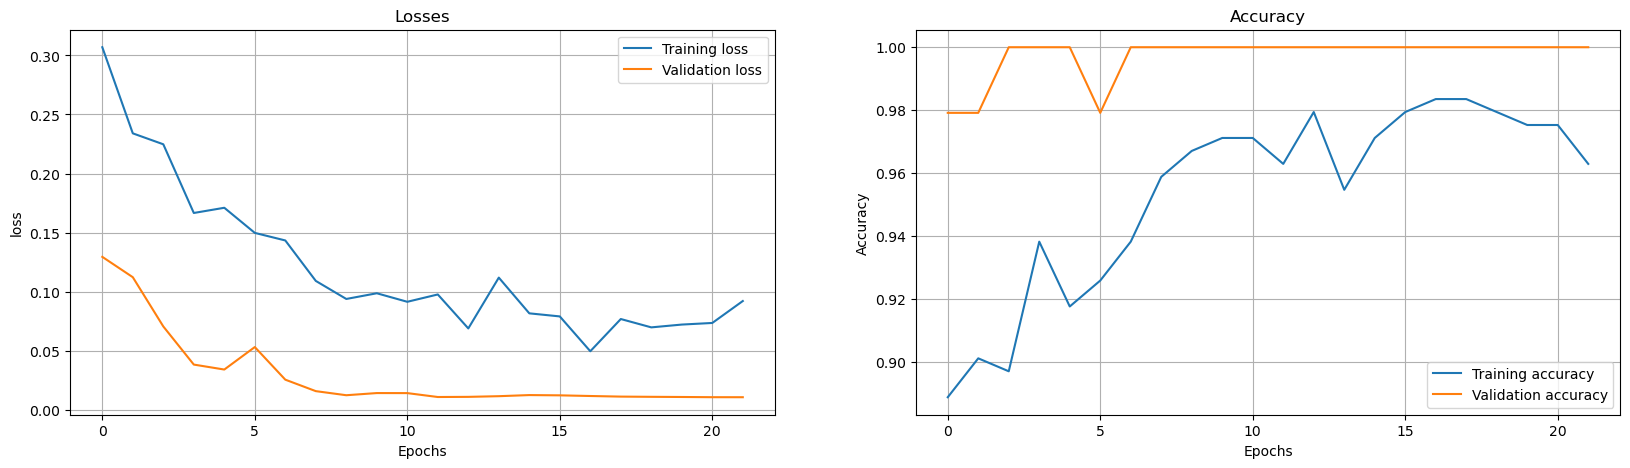

In [25]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [26]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)
test_result = model1.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 1s 886ms/step - loss: 2.0586 - accuracy: 0.6000


,Train,Validation,Testing
Loss,0.019365,0.011552,2.058604
Accuracy,1.000000,1.000000,0.600000


In [27]:
y_pred = model1.predict(test_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = test_ds[0][-1]

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

resnetacc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 1s 1s/step
Confusion matrix:
 [[2 3]
 [1 4]]
Accuracy Score:  0.6
Classification report:
               precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.80      0.57      0.67         7

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



<AxesSubplot:>

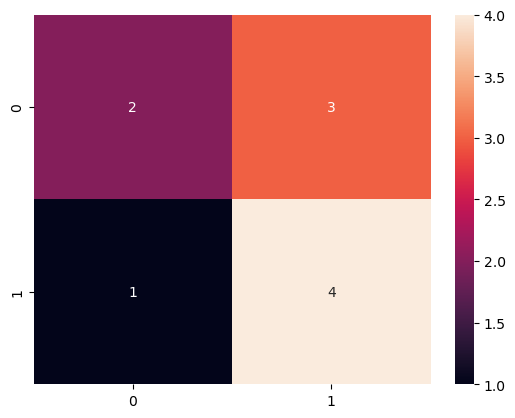

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 2. VGG19


In [29]:
from keras.applications.vgg19 import VGG19

In [30]:
tf.keras.backend.clear_session()

#initializing new height and width for images
height=224
width=224

train_ds, val_ds, test_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Flatten(),
    #Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [31]:
model2.compile(loss="binary_crossentropy", 
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 9.4946 - accuracy: 0.5128 
Epoch 1: accuracy improved from -inf to 0.51282, saving model to model/vgg19_best.h5
7/7 [==============================] - 14s 2s/step - loss: 9.4946 - accuracy: 0.5128 - val_loss: 1.9106 - val_accuracy: 0.7083
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.8250 - accuracy: 0.7231
Epoch 2: accuracy improved from 0.51282 to 0.72308, saving model to model/vgg19_best.h5
7/7 [==============================] - 2s 267ms/step - loss: 1.8250 - accuracy: 0.7231 - val_loss: 2.8696 - val_accuracy: 0.8125
Epoch 3/30
6/7 [========================>.....] - ETA: 0s - loss: 1.3140 - accuracy: 0.8229
Epoch 3: accuracy improved from 0.72308 to 0.82051, saving model to model/vgg19_best.h5
7/7 [==============================] - 2s 247ms/step - loss: 1.3341 - accuracy: 0.8205 - val_loss: 1.6067 - val_accuracy: 0.8125
Epoch 4/30
6/7 [========================>.....] - ETA: 0s - loss: 0.8301 - ac

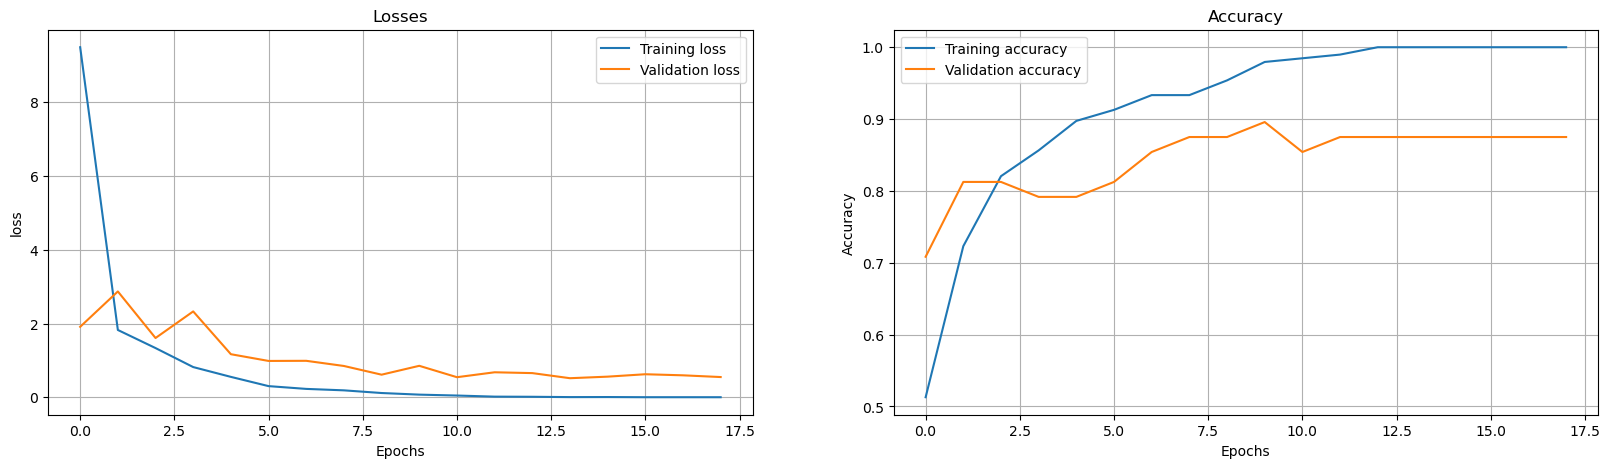

In [32]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [33]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.3,patience=2, 
                                                 min_lr=0.0000001)
callbacks_list = [checkpoint,early, reduce_lr]

history = model2.fit(aug_train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.7695
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 8s 1s/step - loss: 1.1124 - accuracy: 0.7695 - val_loss: 0.5382 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.8189
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 652ms/step - loss: 0.6741 - accuracy: 0.8189 - val_loss: 0.5108 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.8467 - accuracy: 0.7778
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 4s 517ms/step - loss: 0.8467 - accuracy: 0.7778 - val_loss: 0.3448 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 0.8107
Epoch 4: accuracy did not i

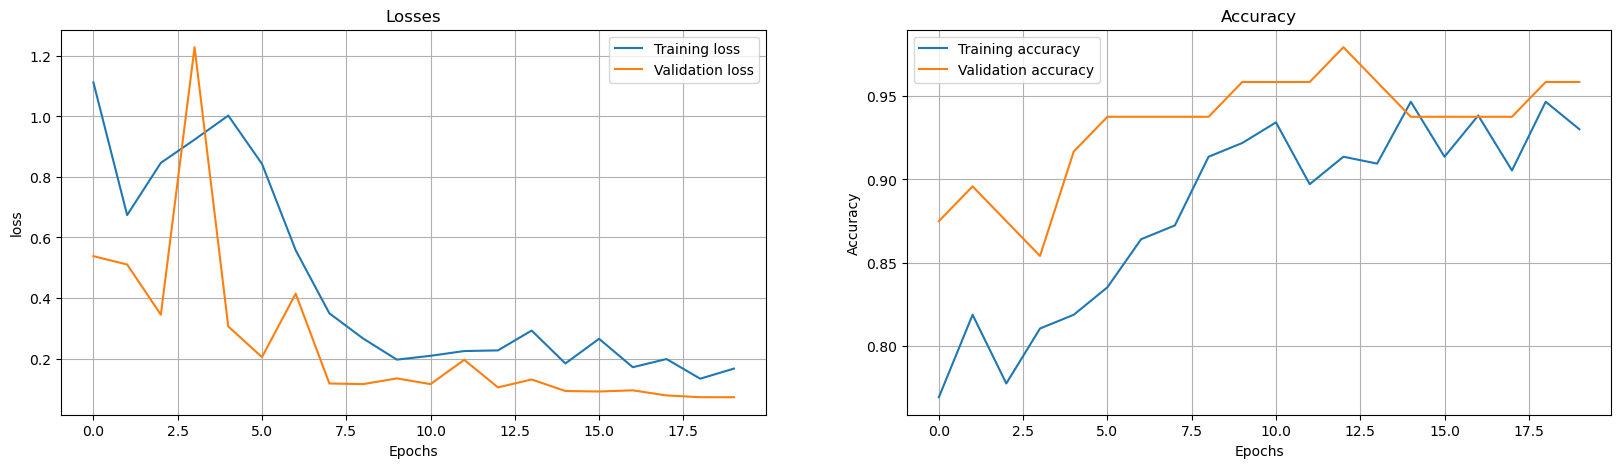

In [34]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [35]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)
test_result = model2.evaluate(test_ds)

model2_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model2_result

1/1 [==============================] - 3s 3s/step - loss: 2.2950 - accuracy: 0.5000


,Train,Validation,Testing
Loss,0.009075,0.092598,2.29502
Accuracy,1.000000,0.937500,0.50000


In [36]:
y_pred = model2.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

vgg19acc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 0s 170ms/step
Confusion matrix:
 [[3 2]
 [3 2]]
Accuracy Score:  0.5
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.40      0.50      0.44         4

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.52      0.50      0.51        10



<AxesSubplot:>

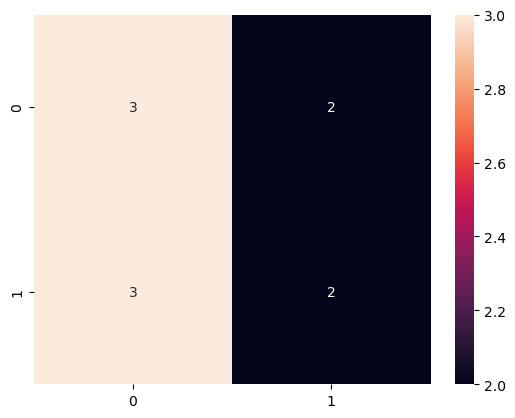

In [37]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 3. InceptionV3



In [38]:
from keras.applications import InceptionV3

In [39]:
height=299
width=299

train_ds, val_ds, test_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = InceptionV3(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model3.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model3.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 24.6080 - accuracy: 0.6667
Epoch 1: accuracy improved from -inf to 0.66667, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 13s 1s/step - loss: 24.6080 - accuracy: 0.6667 - val_loss: 10.1696 - val_accuracy: 0.8958
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 12.6416 - accuracy: 0.8821
Epoch 2: accuracy improved from 0.66667 to 0.88205, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 2s 362ms/step - loss: 12.6416 - accuracy: 0.8821 - val_loss: 18.0803 - val_accuracy: 0.8750
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 13.4672 - accuracy: 0.8410
Epoch 3: accuracy did not improve from 0.88205
7/7 [==============================] - 2s 244ms/step - loss: 13.4672 - accuracy: 0.8410 - val_loss: 12.0966 - val_accuracy: 0.9167
Epoch 4/30
6/7 [========================>.....] - ETA: 0s - loss: 11.8656 - accuracy: 0.8854
Epoch

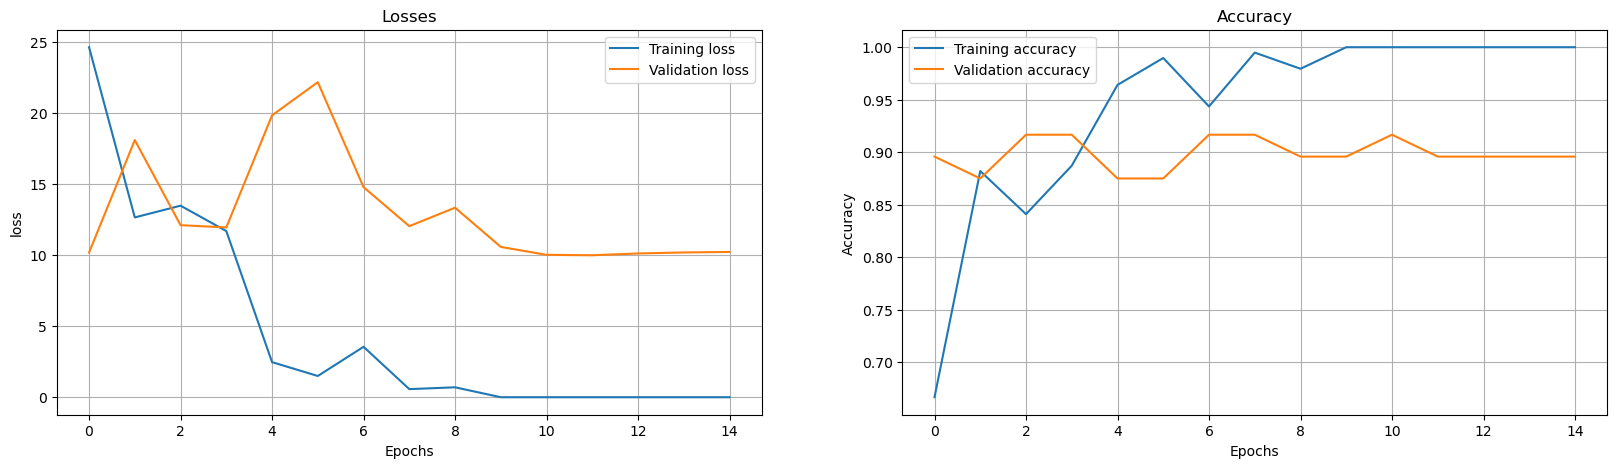

In [41]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [42]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model3.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 16.2664 - accuracy: 0.8148
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 8s 996ms/step - loss: 16.2664 - accuracy: 0.8148 - val_loss: 10.9358 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 17.8553 - accuracy: 0.8066
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 782ms/step - loss: 17.8553 - accuracy: 0.8066 - val_loss: 6.0878 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 9.6515 - accuracy: 0.8971
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 903ms/step - loss: 9.6515 - accuracy: 0.8971 - val_loss: 6.8201 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 7.2245 - accuracy: 0.9012
Epoch 4: accuracy d

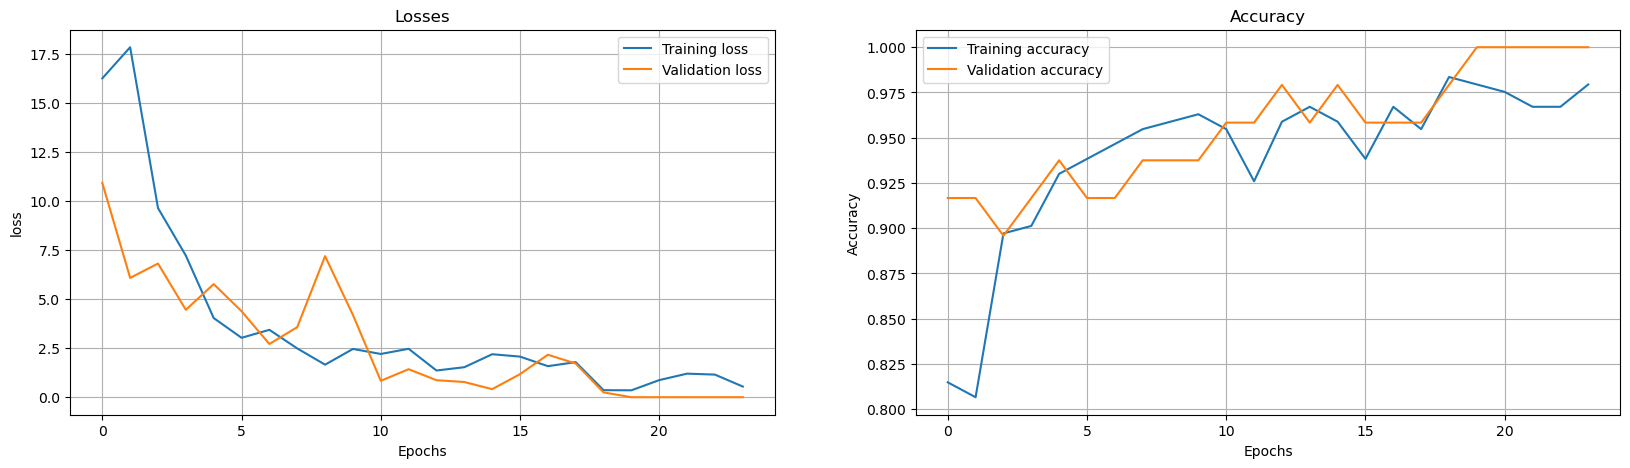

In [43]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [44]:
train_result = model3.evaluate(train_ds)
val_result = model3.evaluate(val_ds)
test_result = model3.evaluate(test_ds)

model3_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model3_result

1/1 [==============================] - 1s 1s/step - loss: 38.5240 - accuracy: 0.7000


,Train,Validation,Testing
Loss,0.000001,0.246312,38.524006
Accuracy,1.000000,0.979167,0.700000


In [45]:
y_pred = model3.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

inceptionacc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 1s 1s/step
Confusion matrix:
 [[2 3]
 [0 5]]
Accuracy Score:  0.7
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.62      0.77         8

    accuracy                           0.70        10
   macro avg       0.70      0.81      0.67        10
weighted avg       0.88      0.70      0.73        10



<AxesSubplot:>

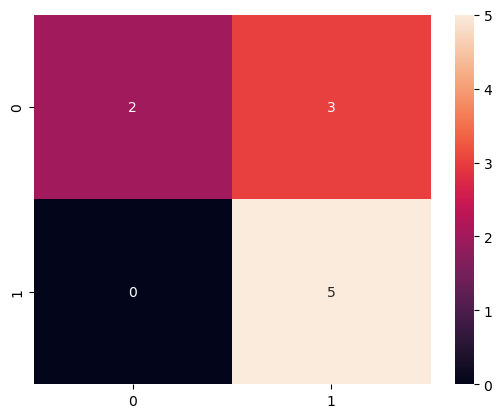

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 4. MobileNetV2

In [47]:
from keras.applications import MobileNetV2

In [48]:
height=299
width=299

train_ds, val_ds, test_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = MobileNetV2(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model4 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model4.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model4.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 1)                 128001    
                                                                 
Total params: 2,385,985
Trainable params: 128,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model4.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 35.8032 - accuracy: 0.6000
Epoch 1: accuracy improved from -inf to 0.60000, saving model to model/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
7/7 [==============================] - 7s 550ms/step - loss: 35.8032 - accuracy: 0.6000 - val_loss: 24.3527 - val_accuracy: 0.7917
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 16.0447 - accuracy: 0.8462
Epoch 2: accuracy improved from 0.60000 to 0.84615, saving model to model/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
7/7 [==============================] - 2s 300ms/step - loss: 16.0447 - accuracy: 0.8462 - val_loss: 16.6456 - val_accuracy: 0.8958
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 4.9943 - accuracy: 0.9128
Epoch 3: accuracy improved from 0.84615 to 0.91282, saving model to model/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
7/7 [==============================] - 2s 2

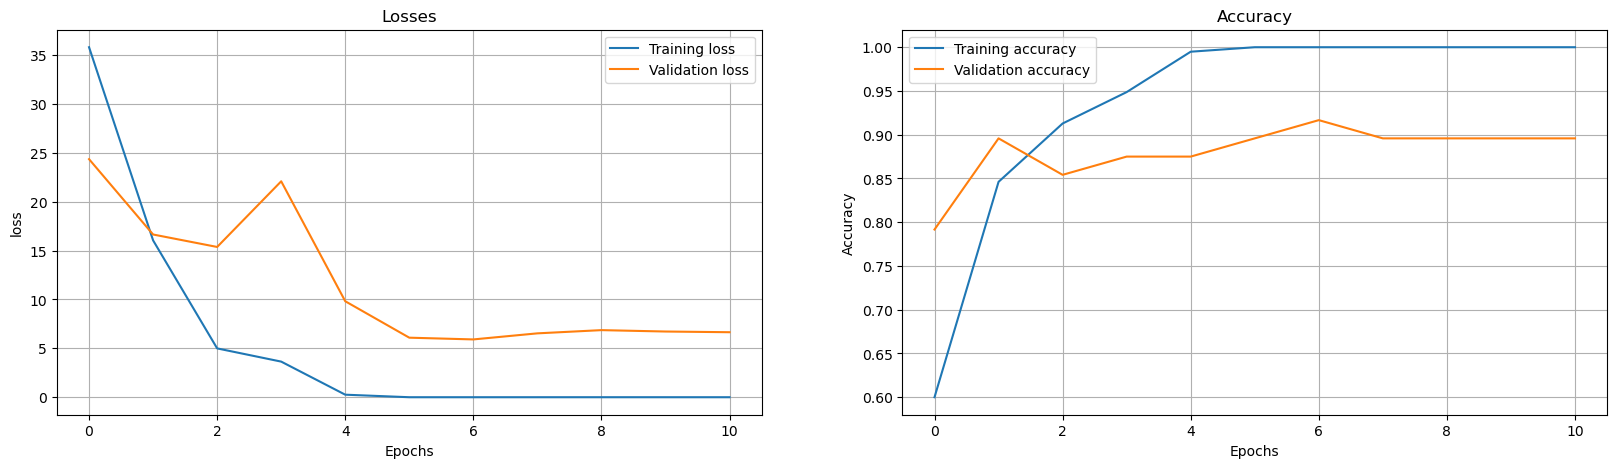

In [50]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [51]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model4.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 8.0714 - accuracy: 0.8889
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 894ms/step - loss: 8.0714 - accuracy: 0.8889 - val_loss: 4.7999 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 8.7107 - accuracy: 0.9053
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 823ms/step - loss: 8.7107 - accuracy: 0.9053 - val_loss: 7.8957 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 3.2239 - accuracy: 0.9342
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 759ms/step - loss: 3.2239 - accuracy: 0.9342 - val_loss: 2.4425 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 3.7168 - accuracy: 0.9424
Epoch 4: accuracy did no

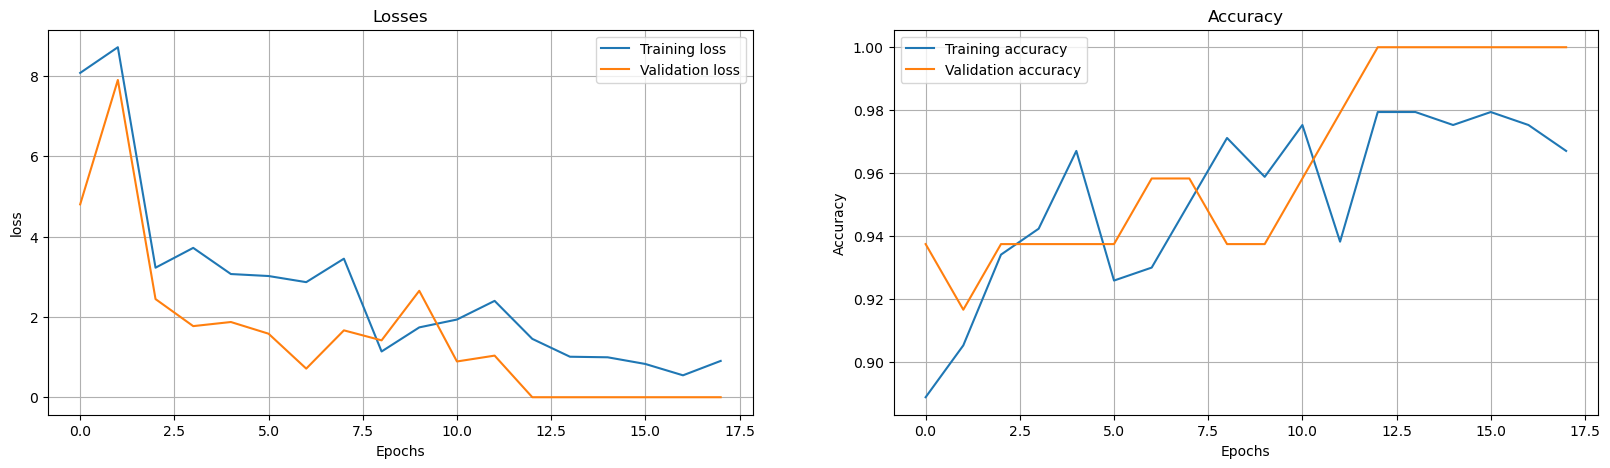

In [52]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [53]:
train_result = model4.evaluate(train_ds)
val_result = model4.evaluate(val_ds)
test_result = model4.evaluate(test_ds)

model4_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model4_result

1/1 [==============================] - 1s 628ms/step - loss: 28.3633 - accuracy: 0.7000


,Train,Validation,Testing
Loss,4.657280e-24,1.934702e-08,28.363287
Accuracy,1.000000e+00,1.000000e+00,0.700000


In [54]:
y_pred = model3.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

mobilenetv2acc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 0s 489ms/step
Confusion matrix:
 [[2 3]
 [0 5]]
Accuracy Score:  0.7
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.62      0.77         8

    accuracy                           0.70        10
   macro avg       0.70      0.81      0.67        10
weighted avg       0.88      0.70      0.73        10



<AxesSubplot:>

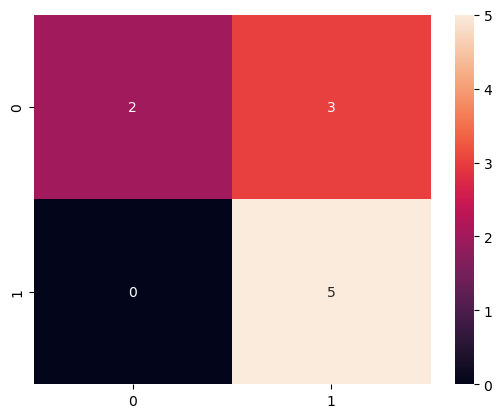

In [55]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 5. DenseNet

In [56]:
from keras.applications import DenseNet121

In [57]:
height=299
width=299

train_ds, val_ds, test_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = DenseNet121(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model5 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model5.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model5.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 1)                 82945     
                                                                 
Total params: 7,120,449
Trainable params: 82,945
Non-trainable params: 7,037,504
_________________________________________________________________


In [58]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model5.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 48.3011 - accuracy: 0.6000
Epoch 1: accuracy improved from -inf to 0.60000, saving model to model/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5.h5
7/7 [==============================] - 20s 2s/step - loss: 48.3011 - accuracy: 0.6000 - val_loss: 15.5357 - val_accuracy: 0.8125
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 29.4795 - accuracy: 0.7487
Epoch 2: accuracy improved from 0.60000 to 0.74872, saving model to model/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5.h5
7/7 [==============================] - 3s 457ms/step - loss: 29.4795 - accuracy: 0.7487 - val_loss: 15.9150 - val_accuracy: 0.8542
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 15.0249 - accuracy: 0.8205
Epoch 3: accuracy improved from 0.74872 to 0.82051, saving model to model/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5.h5
7/7 [==============================] - 3s 439ms/step - loss: 15.0

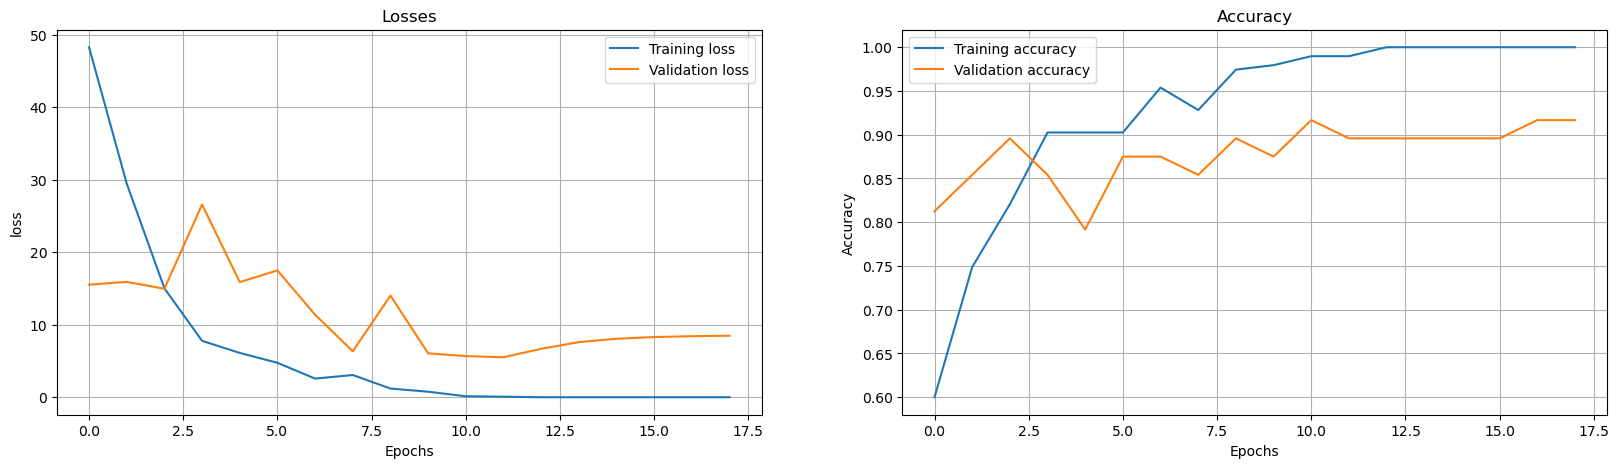

In [59]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [60]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model5.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 7.6335 - accuracy: 0.8601
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 10s 1s/step - loss: 7.6335 - accuracy: 0.8601 - val_loss: 4.2571 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 6.8211 - accuracy: 0.8724
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 847ms/step - loss: 6.8211 - accuracy: 0.8724 - val_loss: 5.1319 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 4.2343 - accuracy: 0.8889
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 856ms/step - loss: 4.2343 - accuracy: 0.8889 - val_loss: 4.9649 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 5.4415 - accuracy: 0.8930
Epoch 4: accuracy did not 

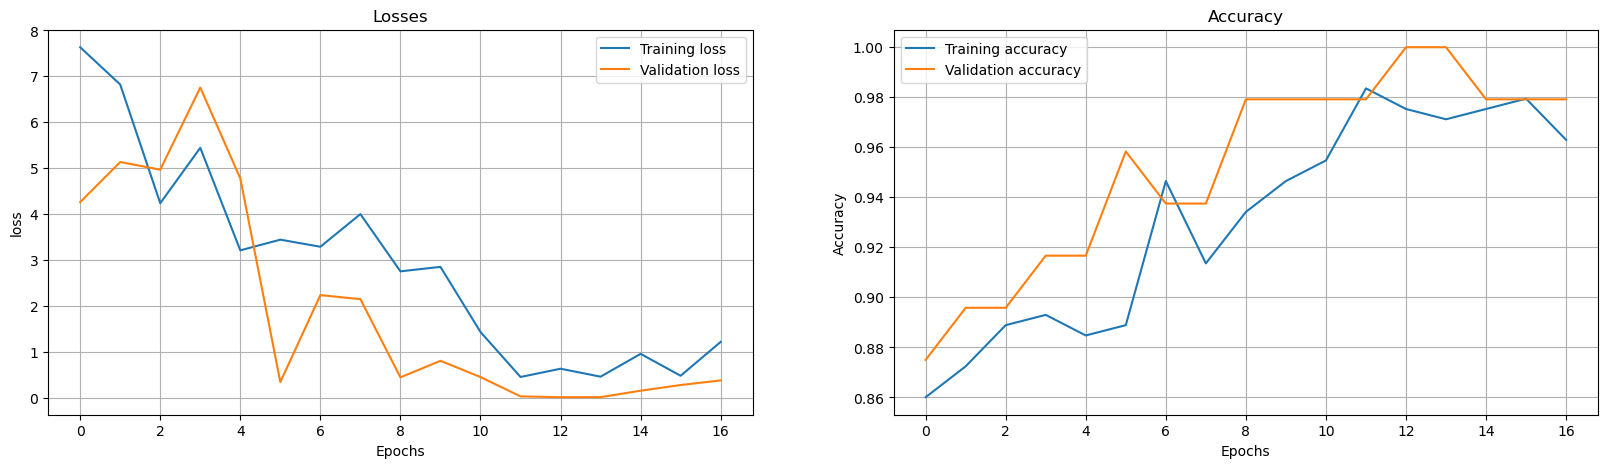

In [61]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [62]:
train_result = model5.evaluate(train_ds)
val_result = model5.evaluate(val_ds)
test_result = model5.evaluate(test_ds)

model5_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model5_result

1/1 [==============================] - 3s 3s/step - loss: 47.8613 - accuracy: 0.7000


,Train,Validation,Testing
Loss,4.025590e-10,0.024893,47.861336
Accuracy,1.000000e+00,0.979167,0.700000


In [63]:
y_pred = model5.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

densenetacc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 2s 2s/step
Confusion matrix:
 [[2 3]
 [0 5]]
Accuracy Score:  0.7
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.62      0.77         8

    accuracy                           0.70        10
   macro avg       0.70      0.81      0.67        10
weighted avg       0.88      0.70      0.73        10



<AxesSubplot:>

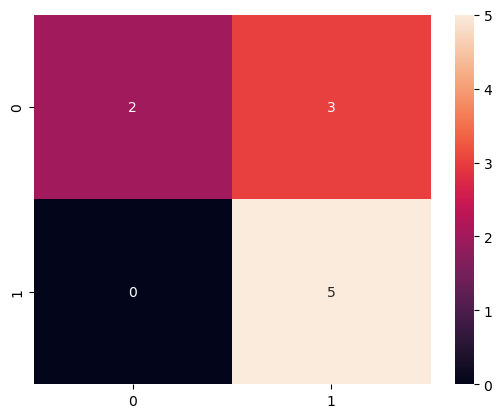

In [64]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 6. NASNetMobile

In [65]:
from keras.applications import NASNetMobile

In [66]:
height=299
width=299

train_ds, val_ds, test_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = NASNetMobile(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model6 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model6.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model6.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
19993432/19993432 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 10, 10, 1056)      4269716   
                                                                 
 flatten (Flatten)           (None, 105600)            0         
                                                                 
 dense (Dense)               (None, 1)                 105601    
                                                                 
Total params: 4,375,317
Trainable params: 105,601
Non-trainable params: 4,269,716
_________________________________________________________________


In [67]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/NASNet-mobile-no-top.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model6.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 22.4031 - accuracy: 0.5538
Epoch 1: accuracy improved from -inf to 0.55385, saving model to model/NASNet-mobile-no-top.h5
7/7 [==============================] - 24s 1s/step - loss: 22.4031 - accuracy: 0.5538 - val_loss: 12.5330 - val_accuracy: 0.7917
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 4.5629 - accuracy: 0.8872
Epoch 2: accuracy improved from 0.55385 to 0.88718, saving model to model/NASNet-mobile-no-top.h5
7/7 [==============================] - 3s 537ms/step - loss: 4.5629 - accuracy: 0.8872 - val_loss: 12.9467 - val_accuracy: 0.8750
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 2.7592 - accuracy: 0.9231
Epoch 3: accuracy improved from 0.88718 to 0.92308, saving model to model/NASNet-mobile-no-top.h5
7/7 [==============================] - 4s 526ms/step - loss: 2.7592 - accuracy: 0.9231 - val_loss: 10.7210 - val_accuracy: 0.9167
Epoch 4/30
7/7 [===========================

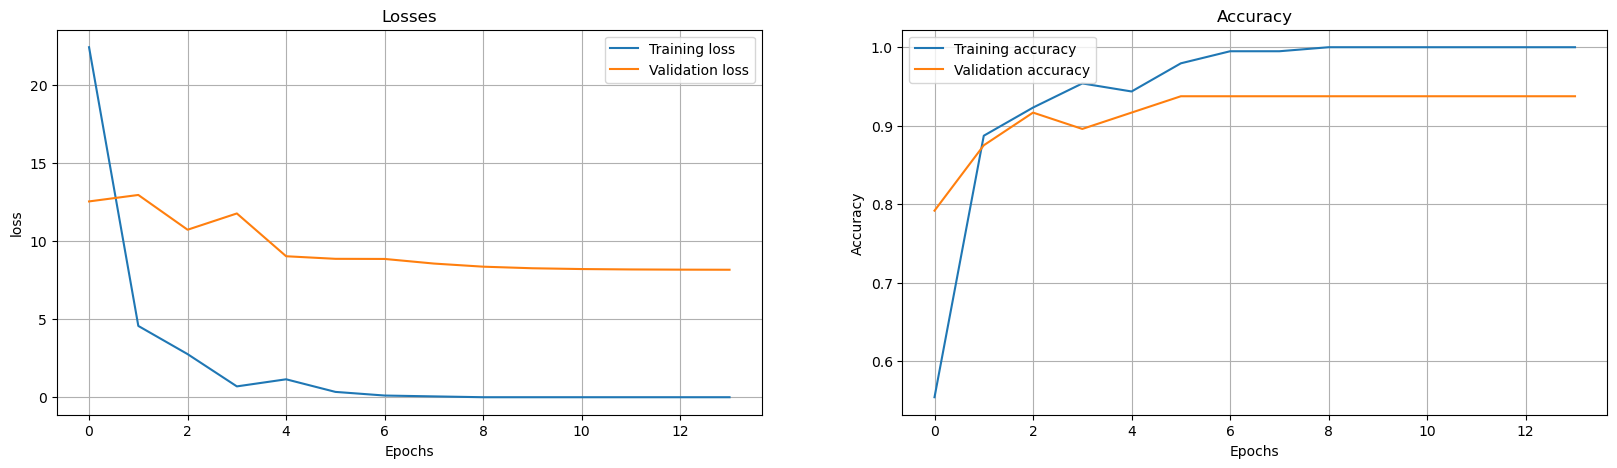

In [68]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [69]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model6.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 9.0411 - accuracy: 0.8313
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 929ms/step - loss: 9.0411 - accuracy: 0.8313 - val_loss: 6.7469 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 4.6297 - accuracy: 0.8807
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 849ms/step - loss: 4.6297 - accuracy: 0.8807 - val_loss: 6.5705 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 5.8959 - accuracy: 0.8354
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 906ms/step - loss: 5.8959 - accuracy: 0.8354 - val_loss: 2.7977 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 3.0845 - accuracy: 0.8807
Epoch 4: accuracy did no

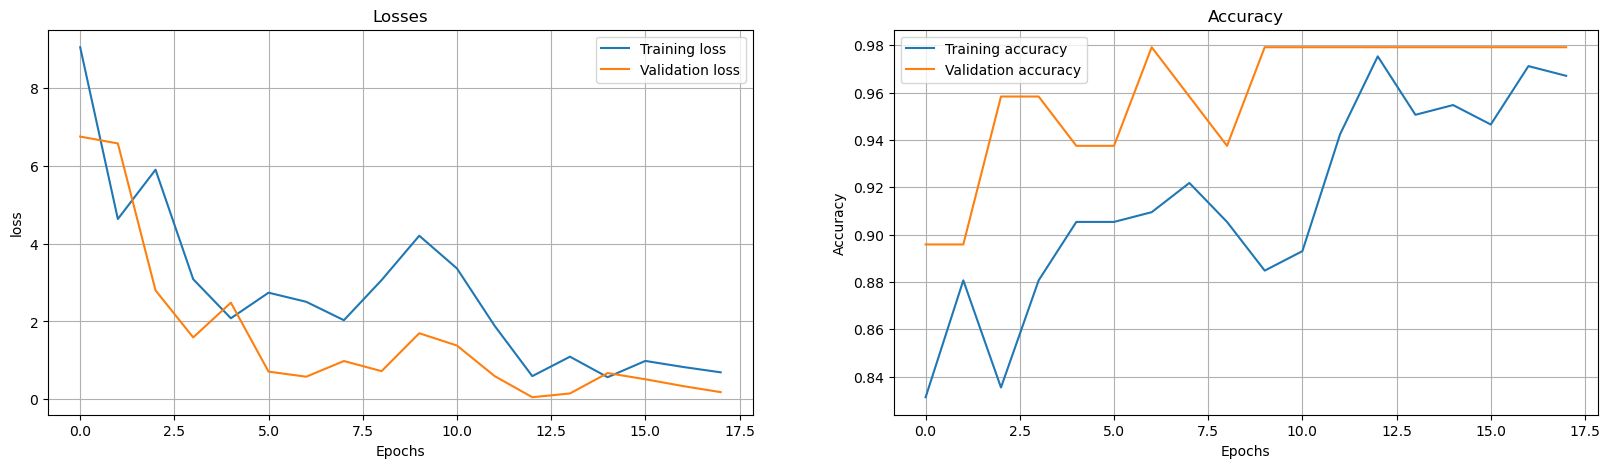

In [70]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [71]:
train_result = model6.evaluate(train_ds)
val_result = model6.evaluate(val_ds)
test_result = model6.evaluate(test_ds)

model6_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model6_result

1/1 [==============================] - 0s 432ms/step - loss: 23.3119 - accuracy: 0.7000


,Train,Validation,Testing
Loss,0.305753,0.054151,23.311892
Accuracy,0.979487,0.979167,0.700000


In [72]:
y_pred = model6.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

nasnetmobileacc=accuracy_score(y_test,y_pred)

1/1 [==============================] - 5s 5s/step
Confusion matrix:
 [[3 2]
 [1 4]]
Accuracy Score:  0.7
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.80      0.67      0.73         6

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10



<AxesSubplot:>

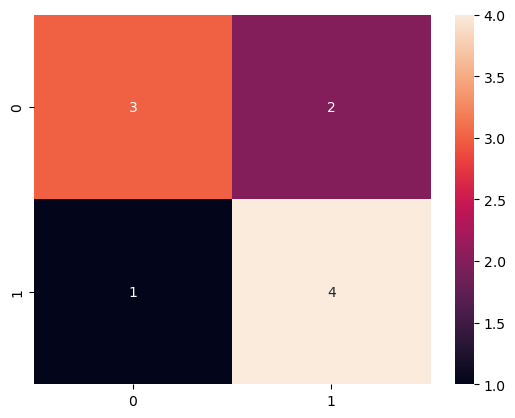

In [73]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

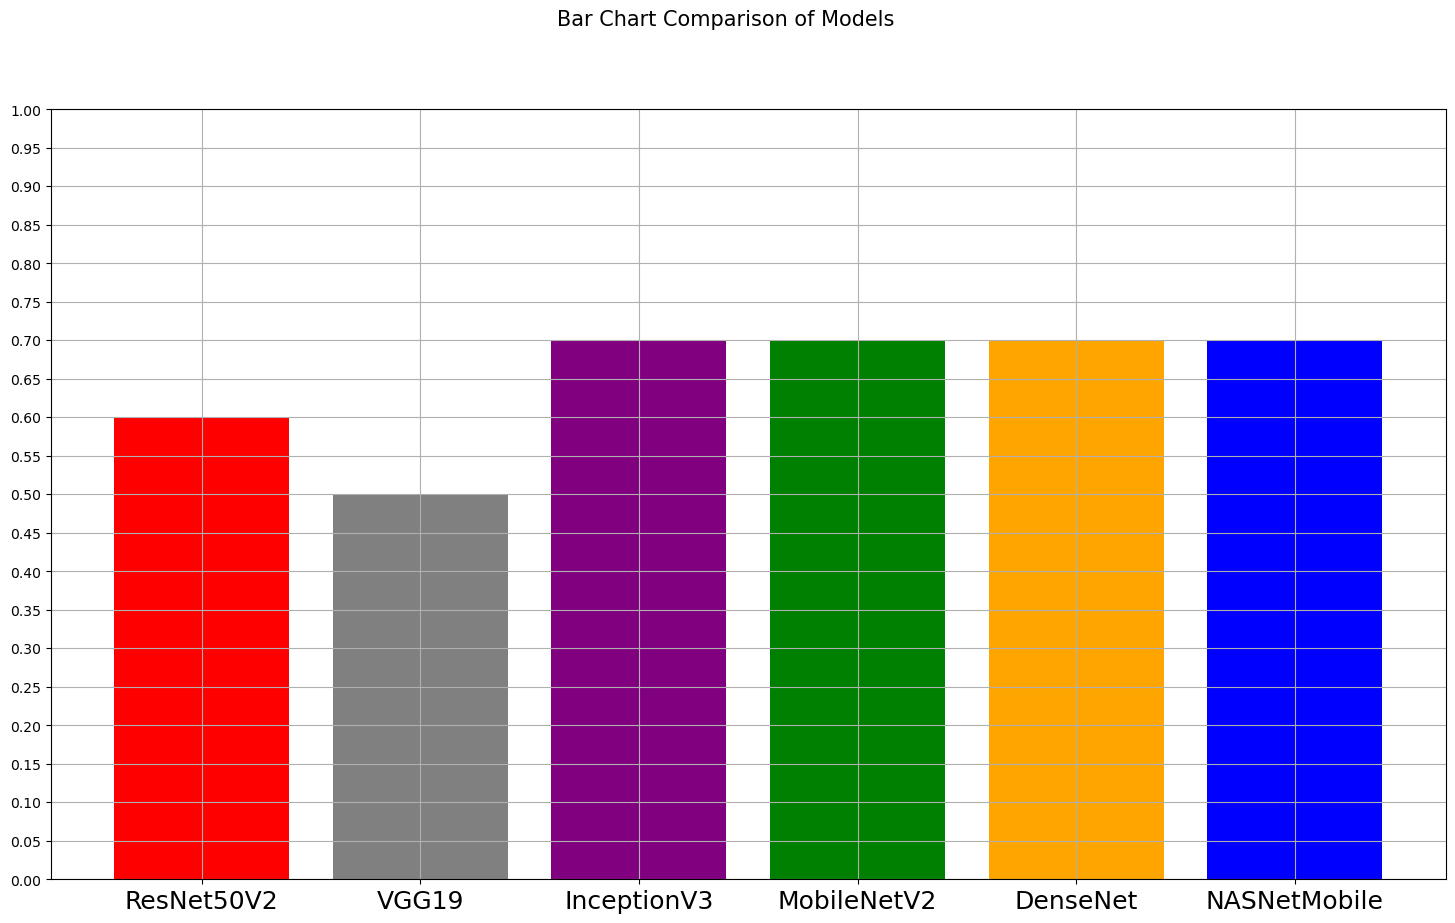

In [74]:
algorithms=("ResNet50V2","VGG19","InceptionV3","MobileNetV2","DenseNet","NASNetMobile")
scores = (resnetacc,vgg19acc,inceptionacc,mobilenetv2acc,densenetacc,nasnetmobileacc)
y_pos = np.arange(1,7)
colors = ("red","gray","purple","green","orange","blue")
plt.figure(figsize=(18,10))
plt.bar(y_pos,scores,color=colors)
plt.xticks(y_pos,algorithms,fontsize=18)
plt.yticks(np.arange(0.00, 1.01, step=0.05))
plt.grid()
plt.suptitle("Bar Chart Comparison of Models",fontsize=15)
plt.show()

In [75]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

historycmp = model6.fit(aug_train_ds, validation_data=val_ds, epochs=50, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.9671
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 918ms/step - loss: 0.6458 - accuracy: 0.9671 - val_loss: 0.2149 - val_accuracy: 0.9792 - lr: 9.0000e-04
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.8706 - accuracy: 0.9465
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 826ms/step - loss: 0.8706 - accuracy: 0.9465 - val_loss: 0.5385 - val_accuracy: 0.9792 - lr: 9.0000e-04
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.9588
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 800ms/step - loss: 1.0815 - accuracy: 0.9588 - val_loss: 0.4990 - val_accuracy: 0.9792 - lr: 9.0000e-04
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.9588
Epoch 4: acc

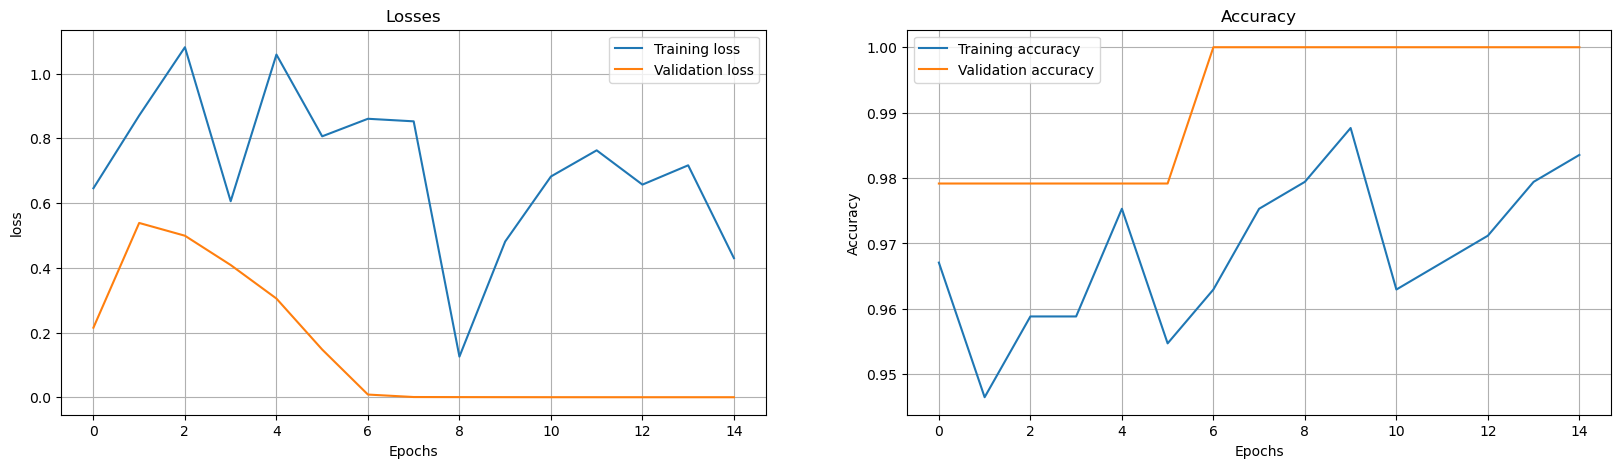

In [76]:
his_data = pd.DataFrame(historycmp.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()